In [1]:
import numpy as np
import astropy as ap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import argparse
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.models import custom_model
from matplotlib.backends.backend_pdf import PdfPages
import scipy as sp
import uncertainties as unc
import uncertainties
from uncertainties import unumpy as unp
import kcorrect
import kcorrect.utils as ut
from astropy.cosmology import FlatLambdaCDM
import pandas as pd
import matplotlib as mp
import os

Defining the Cosmology and initializing fitter

In [2]:
cosmo=FlatLambdaCDM(H0=70.0,Om0=0.3)
fit=LevMarLSQFitter()


**This section has been turned off. It's probably best to not plot the histogram of sources and just put the number of sources in the LF in the table. Will discuss later**


Creating a function that will label the bars in the bar plot as part of the luminosity function

In [3]:
def autolabel(rects,thecolor,row,col,standard_height=0):
    for rect in rects:
        if rect.xy[0]<-16:
            height=rect.get_height()
            if not standard_height:
                if not m.isinf(height):
                    axes[row][col].text(rect.get_x() + rect.get_width()/2.,height+0.05,'{}'.format(int(np.round(np.power(10,height)))),ha='center',va='bottom',fontsize=7,color=thecolor)
            else:
                if not m.isinf(height):
                    axes[row][col].text(rect.get_x() + rect.get_width()/2.,standard_height,'{}'.format(int(np.round(np.power(10,height)))),ha='center',va='bottom',fontsize=7,color=thecolor)

Astropy model to fit the estimated luminosity function with a schechter function

In [4]:
@custom_model
def schechter_func(x,phistar=0.0056,mstar=-21,alpha=-1.03):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(alpha+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

Scipy model to fit the estimated luminosity function with a schechter function

In [5]:
def schechter_func_scipy(x,phistar,mstar,alpha):
    return (0.4*np.log(10)*phistar)*(10**(0.4*(alpha+1)*(mstar-x)))*(np.e**(-np.power(10,0.4*(mstar-x))))

Below will do the astropy fitting for a redshift range, given the dataframe and an optional mask array

In [6]:
def ap_fitting(DATAFRAME,MASK=None):
    if MASK is None:
        MASK=[]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    print(NUMBDENS.compressed())
    #******MODELLING******
    LFFIT_INIT=schechter_func()
    LFFIT=fit(LFFIT_INIT,MBINAVE.compressed(),NUMBDENS.compressed(),weights=1/NUMBDENSERR.compressed())
    return LFFIT,NUMBDENS.mask

Below will do the scipy fitting for a redshift range, given the dataframe and an optional mask array
Scipy fitting gives a more robust estimate of the errors involved with a fit

In [7]:
def sp_fitting(DATAFRAME,MASK=None,INITARRAY=None):
    if MASK is None:
        MASK=[]
    if INITARRAY==None:
        INITARRAY=[0.0056,-21,-1.03]
    #******CREATE MASK ARRAY******
    NUMBDENS=np.ma.array(np.array(DATAFRAME['Number_Density']),mask=False)
    MBINAVE=np.ma.array(np.array(DATAFRAME['Average_Absolute_Magnitude']),mask=False)
    NUMBDENSERR=np.ma.array(np.array(DATAFRAME['Number_Density_Error']),mask=False)
    #******MASK ZEROS******
    NUMBDENS.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    MBINAVE.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
    NUMBDENSERR.mask[DATAFRAME.loc[DATAFRAME.Number_Density==0].index]=True
     #******MASK POINTS I DON'T LIKE******
    NUMBDENS.mask[MASK]=True
    MBINAVE.mask[MASK]=True
    NUMBDENSERR.mask[MASK]=True
    #******MODELLING******
    LFFIT,LFCOV=sp.optimize.curve_fit(schechter_func_scipy,MBINAVE.compressed(),NUMBDENS.compressed(),p0=INITARRAY,sigma=NUMBDENSERR.compressed())
    return LFFIT,LFCOV

## Import data using pandas

Import LCBG data

In [8]:
LCBG_DIR='/Users/lucashunt/Projects/LCBG_LUMINOSITY_FUNCTION/LCBGLFOUT/zucca_z_bins/'
LCBG_LFS={}
LCBG_LFS_INDEX=[]
for file in os.listdir(LCBG_DIR):
    if file.endswith('csv'):
        print(file)
        LCBG_LFS[file.split('.csv')[0]]=pd.read_csv(LCBG_DIR+'/'+file)
        LCBG_LFS_INDEX.append(file.split('.csv')[0])
LCBG_LFS[LCBG_LFS_INDEX[1]]

LF_10_35_LCBG.csv
LF_35_55_LCBG.csv
LF_55_75_LCBG.csv
LF_75_100_LCBG.csv


,Unnamed: 0,Absolute_Magnitude_Bin,Average_Absolute_Magnitude,Average_Comoving_Volume,Average_Weight,Number_Density,Number_Density_Error,Number_Of_Gals,Log10Phi,Log10Err
0,0,-23.75,NaN,NaN,NaN,0.000000,0.000000,0,-inf,NaN
1,1,-23.25,NaN,NaN,NaN,0.000000,0.000000,0,-inf,NaN
2,2,-22.75,-22.792689,624324.331802,1.545194,0.000010,0.000006,2,-5.004367,0.247046
3,3,-22.25,-22.212796,624324.331802,1.624786,0.000021,0.000008,4,-4.681524,0.170356
4,4,-21.75,-21.738989,624324.331802,1.629257,0.000099,0.000018,19,-4.003637,0.078057
5,5,-21.25,-21.226322,624324.331802,1.586008,0.000290,0.000030,57,-3.538200,0.045677
6,6,-20.75,-20.728080,624324.331802,1.602183,0.000539,0.000042,105,-3.268479,0.033484
7,7,-20.25,-20.238190,624324.331802,1.666038,0.000854,0.000052,160,-3.068575,0.026600
8,8,-19.75,-19.723517,624324.331802,1.801115,0.001154,0.000061,200,-2.937809,0.022882
9,9,-19.25,-19.256500,624324.331802,2.167190,0.001409,0.000067,203,-2.850987,0.020706


Import Galaxy data

In [9]:
GAL_DIR='/Users/lucashunt/Projects/LCBG_LUMINOSITY_FUNCTION/FULLLFOUT/zucca_z_bins/'
GAL_LFS={}
GAL_LFS_INDEX=[]
for file in os.listdir(GAL_DIR):
    if file.endswith('csv'):
        GAL_LFS[file.split('.csv')[0]]=pd.read_csv(GAL_DIR+'/'+file)
        GAL_LFS_INDEX.append(file.split('.csv')[0])

Make dictionaries for the masks. I selected these masks in an unscientific way. 

In [10]:
LCBG_MASKS={LCBG_LFS_INDEX[0]:[6,8],LCBG_LFS_INDEX[1]:[2,11],LCBG_LFS_INDEX[2]:[],LCBG_LFS_INDEX[3]:[0,1,2,9]}
GAL_MASKS={GAL_LFS_INDEX[0]:[2,3],GAL_LFS_INDEX[1]:[1,2,14,15],GAL_LFS_INDEX[2]:[11,12,13,14],GAL_LFS_INDEX[3]:[9]}

In [11]:
for lf in GAL_LFS_INDEX:
    GAL_MASKS[lf]=GAL_LFS[lf].loc[GAL_LFS[lf].Number_Of_Gals<50].index
for lf in LCBG_LFS_INDEX:
    LCBG_MASKS[lf]=LCBG_LFS[lf].loc[LCBG_LFS[lf].Number_Of_Gals<8].index
    if sum(LCBG_MASKS[LCBG_LFS_INDEX[0]])==153:
        LCBG_MASKS[LCBG_LFS_INDEX[0]]=[]
    

In [12]:
if sum(LCBG_MASKS[LCBG_LFS_INDEX[0]])==153:
    print(sum(LCBG_MASKS[LCBG_LFS_INDEX[0]]))

Automatically fit Schechter Function to LCBGs (both using scipy and astropy fitting routine

In [13]:
LCBG_FITS_AP={}
LCBG_FITS_AP_INDEX=[]
for index in LCBG_LFS_INDEX:
    LCBG_FITS_AP[index.split('LF_')[-1]+'_ap_fit']=ap_fitting(LCBG_LFS[index],MASK=LCBG_MASKS[index])
    LCBG_FITS_AP_INDEX.append(index.split('LF_')[-1]+'_ap_fit')
LCBG_FITS_SP={}
LCBG_FITS_SP_INDEX=[]
for index in LCBG_LFS_INDEX:
    LCBG_FITS_SP[index.split('LF_')[-1]+'_sp_fit']=sp_fitting(LCBG_LFS[index],MASK=LCBG_MASKS[index])
    LCBG_FITS_SP_INDEX.append(index.split('LF_')[-1]+'_sp_fit')

[ 0.0001839   0.00036261  0.00056077  0.00063396  0.00085122  0.00094532]
[  9.91660177e-05   2.89600906e-04   5.38916003e-04   8.53934550e-04
   1.15396123e-03   1.40933019e-03   2.11629323e-03]
[  2.76136761e-05   1.87570800e-04   5.31741030e-04   9.89825808e-04
   1.70920986e-03   2.45689844e-03   3.77581773e-03   1.94981682e-03]
[  6.19733206e-05   2.96790527e-04   8.58473255e-04   1.78910584e-03
   3.08587169e-03   3.29106484e-03]


Automatically fit Schechter Function to all galaxies (both using scipy and astropy fitting routine

In [14]:
GAL_FITS_AP={}
GAL_FITS_AP_INDEX=[]
for index in GAL_LFS_INDEX:
    GAL_FITS_AP[index.split('LF_')[-1]+'_ap_fit']=ap_fitting(GAL_LFS[index],MASK=GAL_MASKS[index])
    GAL_FITS_AP_INDEX.append(index.split('LF_')[-1]+'_ap_fit')
GAL_FITS_SP={}
GAL_FITS_SP_INDEX=[]
for index in GAL_LFS_INDEX:
    GAL_FITS_SP[index.split('LF_')[-1]+'_sp_fit']=sp_fitting(GAL_LFS[index],MASK=GAL_MASKS[index])
    GAL_FITS_SP_INDEX.append(index.split('LF_')[-1]+'_sp_fit')

[ 0.00106434  0.00189981  0.00317914  0.00423474  0.00478369  0.00616312
  0.00737192  0.00913738  0.00941313  0.00953401  0.0100336   0.01453405]
[ 0.00039984  0.00104195  0.00201965  0.00287976  0.00356894  0.00458882
  0.00545074  0.00798299  0.01023241]
[ 0.00023296  0.00066052  0.00166001  0.00253645  0.00378751  0.00496717
  0.00622042  0.00366762]
[ 0.00032414  0.00095722  0.00206795  0.00360042  0.00514356  0.00559614]


**The below section has been turned off because I don't think the histograms are important (they add information, but how useful is it?)**

Attempt to make a better plot of the five redshift ranges

In [1]:
plt.style.use('seaborn-whitegrid')
plt.style.use('default')
params = {
    'axes.labelsize': 11,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'text.usetex': False,
    'figure.figsize': [7, 4], # instead of 4.5, 4.5
    'grid.linestyle': ':',
    'axes.edgecolor' : '0',
    'font.family':'serif',
    'font.serif':'Computer Modern'
    }
mp.rcParams.update(params)
f=plt.figure(figsize=(7,9.75))
ax1=plt.subplot2grid((52,4),(0,0),colspan=2,rowspan=12)
ax2=plt.subplot2grid((52,4),(0,2),colspan=2,rowspan=12)
ax3=plt.subplot2grid((52,4),(12,0),colspan=2,rowspan=4)
ax4=plt.subplot2grid((52,4),(12,2),colspan=2,rowspan=4)
ax5=plt.subplot2grid((52,4),(17,0),colspan=2,rowspan=12)
ax6=plt.subplot2grid((52,4),(17,2),colspan=2,rowspan=12)
ax7=plt.subplot2grid((52,4),(29,0),colspan=2,rowspan=4)
ax8=plt.subplot2grid((52,4),(29,2),colspan=2,rowspan=4)
ax9=plt.subplot2grid((52,4),(36,1),colspan=2,rowspan=12)
ax10=plt.subplot2grid((52,4),(48,1),colspan=2,rowspan=4)
axes=np.array([[ax1,ax3],[ax2,ax4],[ax5,ax7],[ax6,ax8],[ax9,ax10]])
#axes=np.array([[ax1,ax3],[ax2,ax4],[ax5,ax7],[ax6,ax8]])



plt.subplots_adjust(hspace=0,wspace=0)

x=np.arange(-23,-15,2)
xminor=np.arange(-22,-16,2)
y=np.arange(-5,0,2)
yminor=np.arange(-4,-1,2)

ax1.set_xticks(x)
ax1.set_xticks(xminor,minor=True)
ax1.set_yticks(y)
ax1.set_yticks(yminor,minor=True)
ax1.set_ylim([-5.5,-0.5])
ax1.set_ylabel('Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)')

ax2.set_xticks(x)
ax2.set_xticks(xminor,minor=True)
ax2.set_yticks(y)
ax2.set_yticks(yminor,minor=True)
ax2.set_ylim([-5.5,-0.5])

ax5.set_xticks(x)
ax5.set_xticks(xminor,minor=True)
ax5.set_yticks(y)
ax5.set_yticks(yminor,minor=True)
ax5.set_ylim([-5.5,-0.5])
ax5.set_ylabel('Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)')

ax6.set_xticks(x)
ax6.set_xticks(xminor,minor=True)
ax6.set_yticks(y)
ax6.set_yticks(yminor,minor=True)
ax6.set_ylim([-5.5,-0.5])

ax9.set_xticks(x)
ax9.set_xticks(xminor,minor=True)
ax9.set_yticks(y)
ax9.set_yticks(yminor,minor=True)
ax9.set_ylim([-5.5,-0.5])
ax9.set_ylabel('Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)')

ax3.set_ylim([0,4.2])
ax3.set_yticks([3,1])
#ax3.set_yticks([3.5,2.5,1.5,0.5],minor=True)
ax3.set_xticks(x)
ax3.set_xticks(xminor,minor=True)
ax3.set_ylabel('Log$_{10}$(N)',labelpad=14)

ax4.set_ylim([0,4.2])
ax4.set_yticks([3,1])
#ax4.set_yticks([3.5,2.5,1.5,0.5],minor=True)
ax4.set_xticks(x)
ax4.set_xticks(xminor,minor=True)

ax7.set_ylim([0,4.2])
ax7.set_yticks([3,1])
#ax7.set_yticks([3.5,2.5,1.5,0.5],minor=True)
ax7.set_xticks(x)
ax7.set_xticks(xminor,minor=True)
ax7.set_ylabel('Log$_{10}$(N)',labelpad=14)

ax8.set_ylim([0,4.2])
ax8.set_yticks([3,1])
#ax8.set_yticks([3.5,2.5,1.5,0.5],minor=True)
ax8.set_xticks(x)
ax8.set_xticks(xminor,minor=True)

ax10.set_ylim([0,4.2])
ax10.set_yticks([3,1])
#ax10.set_yticks([3.5,2.5,1.5,0.5],minor=True)
ax10.set_xticks(x)
ax10.set_xticks(xminor,minor=True)
ax10.set_ylim([0,4.2])
ax10.set_ylabel('Log$_{10}$(N)',labelpad=14)
ax10.set_xlabel('M$_{B}$-5log$_{10}$(h$_{70}$)')

ax2.set_yticklabels([])
ax4.set_yticklabels([])
ax6.set_yticklabels([])
ax8.set_yticklabels([])
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax5.set_xticklabels([])
ax6.set_xticklabels([])
ax9.set_xticklabels([])
#ax8.set_yticklabels([])
#axes[2][2].set_yticklabels([])
#ax10.set_yticklabels([])
#axes[3][2].set_yticklabels([])

#ax1.set_yticklabels([-4,-3,-2,-1],fontsize=12)
#ax7.set_yticklabels([-4,-3,-2,-1],fontsize=12)
#ax4.set_yticklabels([3,2,1,0],fontsize=12)
#ax9.set_yticklabels([3,2,1,0],fontsize=12)
#ax4.set_xticklabels([-23,-21,-20,-19,-18,-17,-16],fontsize=12)
#ax5.set_xticklabels([-23,-22,-21,-20,-19,-18,-17,-16],fontsize=12)
#ax6.set_xticklabels([-23,-22,-21,-20,-19,-18,-17,-16],fontsize=12)
#ax9.set_xticklabels([-23,-22,-21,-20,-19,-18,-17,-16],fontsize=12)
#ax10.set_xticklabels([-23,-22,-21,-20,-19,-18,-17,-16],fontsize=12)

ax1.set_xlim([-24,-16])
ax2.set_xlim([-24,-16])
ax3.set_xlim([-24,-16])
ax4.set_xlim([-24,-16])
ax5.set_xlim([-24,-16])
ax6.set_xlim([-24,-16])
ax7.set_xlim([-24,-16])
ax8.set_xlim([-24,-16])
ax9.set_xlim([-24,-16])
ax10.set_xlim([-24,-16])

f.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.1)
#f.text(0.52,0.05,'M$_{B}$-5log$_{10}$(h$_{70}$)',ha='center',va='center',fontsize=16)
#f.text(0.05,0.75,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.35,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.55,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.15,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)
magrange=np.linspace(-24,-16,100)
i=0
for ax_array in axes:
    print(i)
    ax_array[0].errorbar(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude'],GAL_LFS[GAL_LFS_INDEX[i]]['Log10Phi'],yerr=GAL_LFS[GAL_LFS_INDEX[0]]['Log10Err'],xerr=[np.abs(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude']+0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),np.abs(GAL_LFS[GAL_LFS_INDEX[0]]['Average_Absolute_Magnitude']-0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],fmt='o',label='Galaxies',color='black',fillstyle='none')
    ax_array[0].errorbar(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude'],LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Phi'],yerr=LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Err'],xerr=[np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']+0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']-0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],fmt='s',label='LCBGS',color='blue',fillstyle='none')
    ax_array[0].plot(magrange,np.log10(LCBG_FITS_AP[LCBG_FITS_AP_INDEX[i]][0](magrange)),color='blue')
    ax_array[0].plot(magrange,np.log10(GAL_FITS_AP[GAL_FITS_AP_INDEX[i]][0](magrange)),color='black')
    gal_hist=ax_array[1].bar(GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin'],np.log10(GAL_LFS[GAL_LFS_INDEX[i]]['Number_Of_Gals']),np.abs(GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin'][0]-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin'][1]),align='center',label='Number of Galaxies per Absolute Magnitude Bin',color='white',edgecolor='black')
    print('passed gal hist')
    lcbg_hist=ax_array[1].bar(LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin'],np.log10(LCBG_LFS[LCBG_LFS_INDEX[i]]['Number_Of_Gals']),np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin'][0]-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin'][1]),align='center',label='Number of Galaxies per Absolute Magnitude Bin',color='blue',edgecolor='black')
    print('passed lcbg hist')
    autolabel(lcbg_hist,'blue',i,1,standard_height=2.95)
    autolabel(gal_hist,'black',i,1,standard_height=3.45)
    i=i+1
    
plt.show()

NameError: name 'plt' is not defined

Since the formatting looks terrible when including the histogram, I will get rid of it below and just do the Luminosity Function Plots?

Text(0.02, 0.5, 'Log$_{10}$($\\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)')

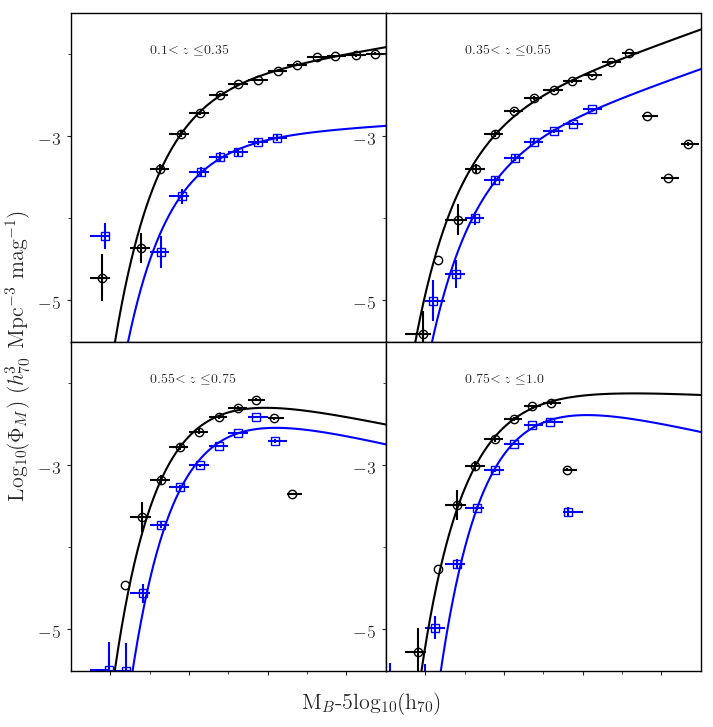

In [24]:
plt.style.use('seaborn-whitegrid')
#plt.style.use('default')
params = {
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'xtick.minor.visible':True,
    'xtick.minor.size':2,
    'xtick.major.size':3,
    'ytick.minor.visible':True,
    'ytick.labelsize': 13,
    'ytick.minor.size':2,
    'ytick.major.size':3,
    'text.usetex': True,
    'figure.figsize': [7, 4], # instead of 4.5, 4.5
    'grid.linestyle': ':',
    'axes.edgecolor' : '0',
    'font.family':'serif',
    'font.serif':'Computer Modern'
    }
mp.rcParams.update(params)
f=plt.figure(figsize=(7,7))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
ax4=plt.subplot(2,2,4)

z_bin_dict={0:'0.1$<z\le$0.35',1:'0.35$<z\le$0.55',2:'0.55$<z\le$0.75',3:'0.75$<z\le$1.0'}
axes=[ax1,ax2,ax3,ax4]

plt.subplots_adjust(hspace=0,wspace=0)

magrange=np.linspace(-24,-16,100)
i=0

x=np.arange(-23,-15,2)
xminor=np.arange(-22,-16,2)
y=np.arange(-5,0,2)
yminor=np.arange(-4,-1,2)

for axe in axes:
    axe.set_xticks(x)
    axe.set_xticks(xminor,minor=True)
    axe.set_yticks(y)
    axe.set_yticks(yminor,minor=True)
    axe.set_ylim([-5.5,-1.5])
    axe.set_xticklabels([])
    axe.grid(False)
    axe.set_xlim([-24,-16])
    axe.errorbar(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude'],
                 GAL_LFS[GAL_LFS_INDEX[i]]['Log10Phi'],
                 yerr=GAL_LFS[GAL_LFS_INDEX[0]]['Log10Err'],
                 xerr=[np.abs(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude']+
                              0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),
                       np.abs(GAL_LFS[GAL_LFS_INDEX[0]]['Average_Absolute_Magnitude']-
                              0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],
                 fmt='o',label='Galaxies',color='black',fillstyle='none')
    axe.errorbar(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude'],
                 LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Phi'],
                 yerr=LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Err'],
                 xerr=[np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']+
                              0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),
                       np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']-
                              0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],
                 fmt='s',label='LCBGS',color='blue',fillstyle='none')
    axe.plot(magrange,np.log10(LCBG_FITS_AP[LCBG_FITS_AP_INDEX[i]][0](magrange)),color='blue')
    axe.plot(magrange,np.log10(GAL_FITS_AP[GAL_FITS_AP_INDEX[i]][0](magrange)),color='black')
    axe.text(-22,-2,z_bin_dict[i])
    i=i+1
f.subplots_adjust(left=0.09, bottom=0.05, right=0.99, top=0.99)
f.text(0.52,0,'M$_{B}$-5log$_{10}$(h$_{70}$)',ha='center',va='center',fontsize=16)
f.text(0.02,0.5,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.35,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.55,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.15,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)

#plt.savefig('LCBG_LUMINOSITY_FUNCTION_NO_HIST.ps')

IndexError: list index out of range

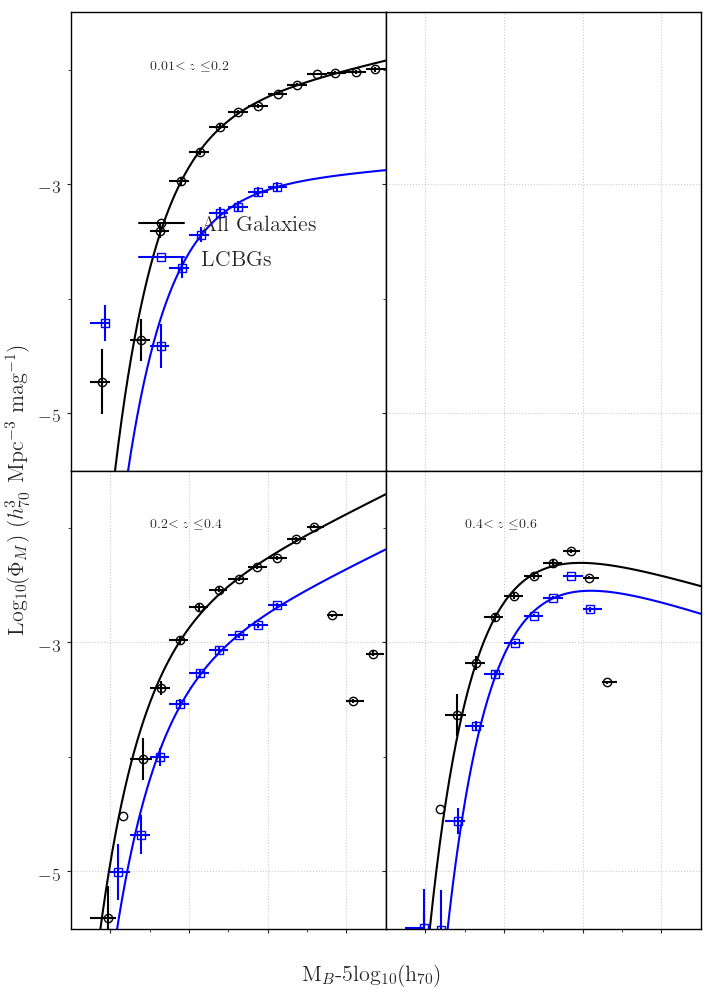

In [25]:
plt.style.use('seaborn-whitegrid')
#plt.style.use('default')
params = {
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 13,
    'xtick.minor.visible':True,
    'xtick.minor.size':2,
    'xtick.major.size':3,
    'ytick.minor.visible':True,
    'ytick.labelsize': 13,
    'ytick.minor.size':2,
    'ytick.major.size':3,
    'text.usetex': True,
    'figure.figsize': [7, 4], # instead of 4.5, 4.5
    'grid.linestyle': ':',
    'axes.edgecolor' : '0',
    'font.family':'serif',
    'font.serif':'Computer Modern'
    }
mp.rcParams.update(params)
f=plt.figure(figsize=(7,9.75))
ax1=plt.subplot(2,2,1)
ax2=plt.subplot(2,2,2)
ax3=plt.subplot(2,2,3)
ax4=plt.subplot(2,2,4)

axes=[ax1,ax3,ax4,ax5,ax6]

plt.subplots_adjust(hspace=0,wspace=0)

x=np.arange(-23,-15,2)
xminor=np.arange(-22,-16,2)
y=np.arange(-5,0,2)
yminor=np.arange(-4,-1,2)

fake_gals=[5,6,7]
fake_mags=[8,9,10]

ax1.set_xticks(x)
ax1.set_xticks(xminor,minor=True)
ax1.set_yticks(y)
ax1.set_yticks(yminor,minor=True)
ax1.set_ylim([-5.5,-1.5])
#ax1.set_ylabel('Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)')
ax1.set_xticklabels([])
ax1.plot(fake_mags,fake_gals,'o-',label='All Galaxies',color='black',fillstyle='none')
ax1.plot(fake_mags,fake_gals,'s-',label='LCBGs',color='blue',fillstyle='none')
ax1.legend(loc='center',fontsize=16)
ax1.grid(False)


ax2.set_xticks(x)
ax2.set_xticks(xminor,minor=True)
ax2.set_yticks(y)
ax2.set_yticks(yminor,minor=True)
ax2.set_ylim([-5.5,-1.5])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

ax3.set_xticks(x)
ax3.set_xticks(xminor,minor=True)
ax3.set_yticks(y)
ax3.set_yticks(yminor,minor=True)
ax3.set_ylim([-5.5,-1.5])
#ax3.set_ylabel('Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)')
ax3.set_xticklabels([])

ax4.set_xticks(x)
ax4.set_xticks(xminor,minor=True)
ax4.set_yticks(y)
ax4.set_yticks(yminor,minor=True)
ax4.set_ylim([-5.5,-1.5])
ax4.set_yticklabels([])
ax4.set_xticklabels([])

ax5.set_xticks(x)
ax5.set_xticks(xminor,minor=True)
ax5.set_yticks(y)
ax5.set_yticks(yminor,minor=True)
ax5.set_ylim([-5.5,-1.5])
#ax5.set_ylabel('Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)')
#ax5.set_xlabel('M$_{B}$-5log$_{10}$(h$_{70}$)')

ax6.set_xticks(x)
ax6.set_xticks(xminor,minor=True)
ax6.set_yticks(y)
ax6.set_yticks(yminor,minor=True)
ax6.set_ylim([-5.5,-1.5])
ax6.set_yticklabels([])
#ax6.set_xlabel('M$_{B}$-5log$_{10}$(h$_{70}$)')

ax1.set_xlim([-24,-16])
ax2.set_xlim([-24,-16])
ax3.set_xlim([-24,-16])
ax4.set_xlim([-24,-16])
ax5.set_xlim([-24,-16])
ax6.set_xlim([-24,-16])

f.subplots_adjust(left=0.09, bottom=0.05, right=0.99, top=0.99)
f.text(0.52,0,'M$_{B}$-5log$_{10}$(h$_{70}$)',ha='center',va='center',fontsize=16)
f.text(0.02,0.5,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.35,'Log$_{10}$($\Phi_{M}$) ($h^{3}_{70}$ Mpc$^{-3}$ mag$^{-1}$)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.55,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)
#f.text(0.05,0.15,'Log$_{10}$(N)',ha='center',va='center',rotation='vertical',fontsize=16)

magrange=np.linspace(-24,-16,100)
i=0
for axe in axes:
    axe.errorbar(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude'],
                 GAL_LFS[GAL_LFS_INDEX[i]]['Log10Phi'],
                 yerr=GAL_LFS[GAL_LFS_INDEX[0]]['Log10Err'],
                 xerr=[np.abs(GAL_LFS[GAL_LFS_INDEX[i]]['Average_Absolute_Magnitude']+
                              0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),
                       np.abs(GAL_LFS[GAL_LFS_INDEX[0]]['Average_Absolute_Magnitude']-
                              0.25-GAL_LFS[GAL_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],
                 fmt='o',label='Galaxies',color='black',fillstyle='none')
    axe.errorbar(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude'],
                 LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Phi'],
                 yerr=LCBG_LFS[LCBG_LFS_INDEX[i]]['Log10Err'],
                 xerr=[np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']+
                              0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin']),
                       np.abs(LCBG_LFS[LCBG_LFS_INDEX[i]]['Average_Absolute_Magnitude']-
                              0.25-LCBG_LFS[LCBG_LFS_INDEX[i]]['Absolute_Magnitude_Bin'])],
                 fmt='s',label='LCBGS',color='blue',fillstyle='none')
    axe.plot(magrange,np.log10(LCBG_FITS_AP[LCBG_FITS_AP_INDEX[i]][0](magrange)),color='blue')
    axe.plot(magrange,np.log10(GAL_FITS_AP[GAL_FITS_AP_INDEX[i]][0](magrange)),color='black')
    if i>0:
        axe.text(-22,-2,'{}$<z\le${}'.format(((i*2)/10),(((i+1)*2)/10)))
    else:
        axe.text(-22,-2,'0.01$<z\le$0.2')
    i=i+1
plt.savefig('LCBG_LUMINOSITY_FUNCTION_NO_HIST.ps')